<a href="https://colab.research.google.com/github/jsehnert/Intro-to-python-for-data-science/blob/master/USSimulations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook for Ultrasound Simulations
Code adapted from Jake Ignjatovic's matlab code

## Comments/Observations
For arrays aligned on opposite side of Tx:
The PSF is smeared across the field in arcs.



###Basic functions

In [ ]:
import math, scipy
import numpy as np
from scipy import signal
from sklearn.linear_model import ElasticNet
from skimage.restoration import denoise_tv_chambolle
from scipy.io import savemat,loadmat
import matplotlib.pyplot as plt
from scipy.io import savemat,loadmat
import matplotlib.patches as patches

%matplotlib inline


In [ ]:


def save_mat_data(fileName, image, zScat, xScat):
  '''
  Save the reconstructed image and scatter locations (z,x) in amatlab file
  '''
  #image input as a 2D numpy array
  rows = image.shape[0]
  cols = image.shape[1]
  print(rows, cols)

  scatterers = np.zeros((len(zScat),2))
  for n in range(len(zScat)):
    scatterers[n,0] = zScat[n]
    scatterers[n,1] = xScat[n]

  mat_dict = {'image' : image, 'scatterers' : scatterers , 'label' : 'Recon hollow cyst'}
  savemat(fileName, mat_dict)
  return

def PlotImage(image, aspect='equal', extent=None, title=None, patch=None):
  '''
  Using the grayscale normalization provided by Jake, plot the image.
  '''
  dbScale = 50
  lowerBound = math.pow(10, -dbScale/20)
  img_abs = np.abs(image)
  img_abs = img_abs/np.amax(img_abs)
  img_abs[img_abs < lowerBound] = lowerBound
  img_abs = 20*np.log10(img_abs)
  #plot the image with scatter density
  fig,ax1 = plt.subplots(figsize=(10,10))
  ax1.xaxis.label.set_color(color='white')
  ax1.set_title(title)
  if ~(patch ==None):
    ax1.add_patch(patch)
  
  pos = plt.imshow(img_abs, cmap='gray',aspect=aspect,interpolation='bicubic',extent=extent)
  fig.colorbar(pos)
  return

def solve( sensing_matrix, rx_data, alpha, lambda_, seed=None):
  '''
  Uses sklearn's built in ElasticNet object to solve.
  NOTE: sklearn does not gpu
  '''
  max_iter=50
  positive=False
  tol=1e-7
  solver = ElasticNet(alpha = alpha, l1_ratio=lambda_, fit_intercept=False, random_state=seed, max_iter=max_iter, positive=positive, tol=tol)
  solver.fit(sensing_matrix, rx_data)
  return solver.coef_


def get_scatterers(cystCtr, rand_reflectance=False):
  '''
  Create a set of random scatterers, uniformly randomly distributed outside of
  a collection of hollow cycsts, each having the same radius
  '''
  np.random.seed=2
  #Set scatterers
  nScat = (zmax - zmin) * (xmax - xmin) * scatDensity
  nScat = int(nScat + 0.5)
  zran = np.random.uniform(zmin+1, zmax-1, size=nScat)
  xran = np.random.uniform(xmin+1, xmax-1, size=nScat)
  refl = np.ones(nScat)
  if( rand_reflectance):
    refl = np.random.uniform(low=0.1,size=nScat)

  zs=[]
  xs=[]
  rs=[]

  #set the scatterers for a single hollow cyst
  for k in range(nScat):
      for pts in cystCtr:
        d = math.sqrt( math.pow(zran[k]-pts[0],2) + math.pow(xran[k]-pts[1],2) )
        if( d > radius ):
          zs.append(zran[k])
          xs.append(xran[k])
          rs.append(refl[k])

  #set the scatterers for solid cyst
  '''for k in range(nScat):
      for pts in cystCtr:
        d = math.sqrt( math.pow(zran[k]-pts[0],2) + math.pow(xran[k]-pts[1],2) )
        if( d < radius ):
          zs.append(zran[k])
          xs.append(xran[k])
          rs.append(refl[k])
'''
  nScat = len(zs)
  return zs,xs,rs,nScat

def WriteParameters():
  '''
  Write out the parameters for the current configuration of 
    - system
    - Object
    - Reconstruction
  '''
  s = 'Receiver locations: '
  tmp = rx_locations[:,1]
  for t in tmp:
    s = s + '{:6.2f}'.format(t)
  print(s)
  print('Scatter density: ' + str(scatDensity))
  print('Number of pulse cycles: ' + str(cycles))
  if( addNoise ): 
      print('Noise added')
  else:
      print('No noise added')
  if( ranReflections ):
    print('Used random reflections')
  else:
    print('Reflections specifified as 1.0')
  s = 'Regularization parameters: lambda={:4.3f}'.format(reg)
  s = s + ', alpha={:4.2f}'.format(sparsity)
  if( len(cystCtr) < 2 ):
    print('Cycst radius: {:4.2f} mm'.format(radius))
  print(s)
  s = 'dx: {:4.2f}'.format(dx) + ' ' + 'dz: {:4.2f}'.format(dz)
  print(s)
  return



In [ ]:
#Load the data
sensing_matrix_file = '.\sensing_matrix_lpf.mat'
receive_data_file = '.\Y_0_0.mat'

### Set up the system parameters
Includes:
- Field of view with coordinates relative to the plane wave transmitter
- Locations of the receiving elements
- Cyst center and radius

In [ ]:
#setup the parameters
def get_parameters():
    addNoise = False
    randomReflections=False
    scatterDensity=1.1

    cycles=3 #Cycles per Tx pulse
    
    #Field of view geometry
    zmin=30
    zmax=80
    xmin=-25
    xmax=25
    dx=.5
    dz=.5
    
    #Set up  the cyst object ()
    #NOTE: The hollow cycst login in get_scatterers() only works for a single
    #      cyst object. Nultiple hollow cysts require an update to that code
    radius=10 
    cystCtr = []
    nCysts=1
    if( nCysts==1 ):
      cystCtr.append([zmin + 0.5*(zmax-zmin), xmin + 0.5*(xmax-xmin)])
    else:  
      cystCtr.append([zmin + 0.2*(zmax-zmin), xmin + 0.2*(xmax-xmin)])
      cystCtr.append([zmin + 0.2*(zmax-zmin), xmin + 0.8*(xmax-xmin)])
      cystCtr.append([zmin + 0.5*(zmax-zmin), xmin + 0.5*(xmax-xmin)])
      cystCtr.append([zmin + 0.8*(zmax-zmin), xmin + 0.2*(xmax-xmin)])
      cystCtr.append([zmin + 0.8*(zmax-zmin), xmin + 0.8*(xmax-xmin)])

    #Theta allows array to be flipped about the Tx positioned at the origin
    theta = 180 * 0
    theta = 2 * math.pi * theta / 360
    offset = 27.
    
    #rx_positions = 1.0*np.array([-8., -6., -4., -2.])
    #rx_positions = 1.0*np.array([-50, -42, -40, -32., -30., -20., -18., -16., -14., -12., -10., -8., -6., -4., -2.])
    #Pretty good rx_positions = 1.0*np.array([-24, -22,-20,-18, -16.,-14,-12,-10, -8.,-6,-4, -2.])
    #Pretty good rx_positions = 1.0*np.array([-20,-18, -16.,-14,-12,-10, -8.,-6,-4, -2.])
    #Decent rx_positions = 1.0*np.array([-16.,-14,-12,-10, -8.,-6,-4, -2.])
    #OK rx_positions = .5*np.array([-12,-10, -8.,-6,-4, -2.])
    #no good rx_positions = 1.*np.array([-49., -36,-25, -16.,-9,-4, -2.])
    #rx_positions = 1.*np.array([-20.,-14,-8, -2.])
    
    rx_positions = 1.0*np.array([-42., -39.,-36.,-33,-30, -27,-24, -21.,-18,-15,-12, -9.,-6, -3.])
    rx_positions = 1.0*np.array([-42., -39.,-33, -27, -21.,-15, -9., -3.])
    #rx_positions = 1.0*np.array([-39, -35, -31, -27, -23, -19., -15., -11, -7,  -3.])
    #rx_positions = 1.0*np.array([-35, -27, -19.,  -11,  -3.])
    
    rx=rx_positions * math.cos(theta)
    rz=rx_positions * math.sin(theta)
    nChannels = len(rx_positions)
    rx_locations = np.zeros((nChannels,2))
    rx_locations[:,0]=rz
    rx_locations[:,1]=rx
    
   
    return (addNoise,zmin,zmax,xmin,xmax,dx,dz,rx_locations,scatterDensity,radius,cystCtr,cycles,randomReflections)


In [ ]:
'''
This block build the system matrix H and generates the (stacked) data vector y
'''

addNoise,zmin,zmax,xmin,xmax,dx,dz,rx_locations,scatDensity,radius,cystCtr,cycles,ranReflections = get_parameters()

#Create a computer model of a cyst phantom
nChannels = rx_locations.shape[0]

zs,xs,rs,nScat = get_scatterers(cystCtr, ranReflections)

phantom = np.array([zs, xs, rs]).T
print(phantom.shape)

#Set the sensing matrix
maxLength = 2000
yLength = nChannels * maxLength
nBlanks = 300
sampFactor = 20
ts = 1 / 12.5e6/ sampFactor #sampling period of the pulse 
c = 1540e3 #speed of sound in mm per s

n = np.array(range(int(24*cycles*sampFactor+0.5)))
pulse = np.sin(2*math.pi*ts*520e3*n)
impulse = scipy.signal.hann(len(n), sym = True) * pulse


rows = int(nChannels * (maxLength-nBlanks) + 0.5)
cols = int((zmax-zmin)/dz * (xmax-xmin)/dx + 0.5)
#print(rows, cols)
H = np.zeros( (rows, cols) )
indx=0
zrange = math.floor((zmax - zmin)/dz)
xrange = math.floor((xmax - xmin)/dx)
for zn in range(zrange):
    zz = zmin + zn*dz
    for xn in range(xrange):
        xx =xmin + dx*xn
        H_temp = []
        for k in range(nChannels):
            delta_z = zz - rx_locations[k,0]
            delta_x = xx - rx_locations[k,1]
            d = math.sqrt(zz*zz + xx*xx) #distance to Tx at (0,0,0)
            d1 = d + math.sqrt( delta_z*delta_z + delta_x*delta_x)
            t1 = d1/c #delay time
            leadZeros = int(math.floor(t1/ts))
            trailZeros = int(sampFactor*maxLength - leadZeros - len(impulse))
            r1 = np.concatenate((np.zeros(leadZeros), impulse, np.zeros(trailZeros)), axis=0)
            r1 = r1[::sampFactor]
            r1 = r1[nBlanks:]
            H_temp = np.concatenate((H_temp, r1), axis=0)
            
        H[:,indx] = H_temp
        indx = indx + 1

print(H.shape)

#Set the data vector
y = np.zeros(len(H_temp))
for m in range(nScat):
    d = math.sqrt(math.pow(zs[m],2) + math.pow(xs[m],2))
    y_temp=[]
    for k in range(nChannels):
        delta_z = zs[m]-rx_locations[k,0]
        delta_x = xs[m]-rx_locations[k,1]
        d1 = d + math.sqrt(delta_z*delta_z + delta_x*delta_x)
        t1 = d1/c
        leadZeros = math.floor(t1/ts)
        trailZeros = int(sampFactor*maxLength - leadZeros - len(impulse))
        r1 = np.concatenate((np.zeros(leadZeros), impulse, np.zeros(trailZeros)), axis=0)
        #print(r1.shape)
        r1 = r1[::sampFactor]
        #print(r1.shape)
        r1 = r1[nBlanks:]
        #print(r1.shape)
        y_temp = np.concatenate((y_temp, r1), axis=0)
    
    y = y + rs[m] * y_temp
    
#optionally add noise
if( addNoise ):
    rms = 0.001
    y = y + rms * np.random.normal(len(y))

(2385, 3)
(13600, 10000)


### Set the system matrix and compute the receive data

# Reconstruction of real 2D data

In [ ]:
#Read the sensing matrx
sensing_file = '/content/Sensing_matrix_lpf.mat'
smat = loadmat(sensing_file)['A']
print(smat)
#smat = np.array(smat)
#smat = smat
print(smat.shape)



[[ 0.02744581  0.0283472   0.03111956 ...  0.01989665  0.02205378
   0.02416674]
 [ 0.02655532  0.02764005  0.03086122 ...  0.02398319  0.02586324
   0.02808513]
 [ 0.02407317  0.02530044  0.02870311 ...  0.02623424  0.02771694
   0.0298634 ]
 ...
 [ 0.00751926  0.01153722  0.00949205 ... -0.00151246 -0.00302287
   0.01385597]
 [ 0.0056464   0.01113324  0.00770294 ... -0.00010071 -0.00378187
   0.01275744]
 [ 0.00320283  0.009808    0.0053318  ...  0.0013324  -0.00404018
   0.01082204]]
(4000, 2091)


(4000, 1)


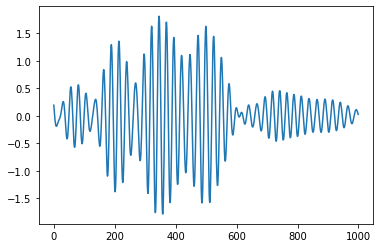

In [ ]:
#Read the data file
data_file = '/content/Y_1.8_-9.mat'
#data_file = '/content/Y_0_0.mat'

rx = loadmat(data_file)['y']
#rx = rx[:,0]
print(rx.shape)

do_filter=False
if do_filter:
  for n in range(501):
    rx[n] = rx[n] * (n/500)
    rx[n+1000] = rx[n+1000] * (n/500)
    rx[n+2000] = rx[n+2000] * (n/500)
    rx[n+3000] = rx[n+3000] * (n/500)

  for n in range(501,1000):
    rx[n] = rx[n] * (2-n/500)
    rx[n+1000] = rx[n+1000] * (2-n/500)
    rx[n+2000] = rx[n+2000] * (2-n/500)
    rx[n+3000] = rx[n+3000] * (2-n/500)

plt.plot(rx[0:1000])
#plt.plot(rx[1000:2000])
#plt.plot(rx[2000:3000])
#plt.plot(rx[3000:4000])
#plt.plot(5*smat[:,100])


In [ ]:
#Solve the system of equations
#compute the resulting image using the ElasticNets reconstructor
reg = 0.1      #lambda
sparsity = 0.001   #alpha

#x = solve(smat,rx,reg,sparsity)
x = np.dot(smat.T,rx)[:,0]

#unravel the image 1D -> 2D
_cols = 41
_rows = 51
phantom = np.zeros((_rows,_cols))
for n in range(_rows):
    phantom[n,:] = x[n*_cols:(n+1)*_cols]

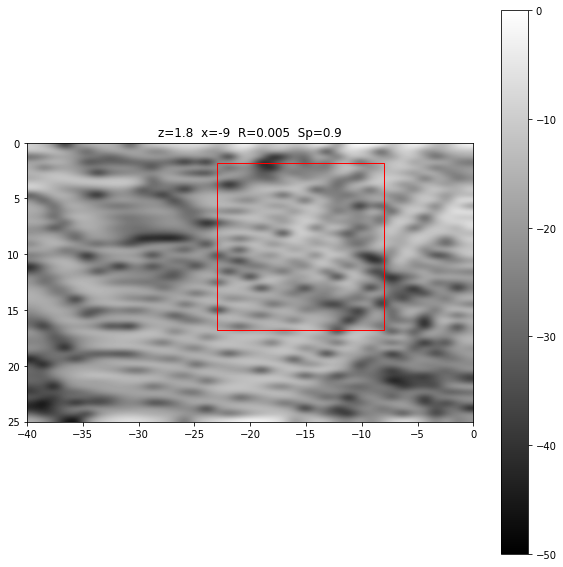

In [ ]:
#print(phantom)
filter = np.array([0.00, .05, .25, .4, .25,  0.05, 0.00])
#filter = np.array([0.00, .00, .0, 1, .0,  0.0, 0.00])
#filter = np.array([0.20, .2, .2, .2, .2,  0.2, 0.20])
filter = np.outer(filter, filter)
smoothed = scipy.signal.convolve2d(phantom, filter, mode='same', boundary='symm')

#smoothed = denoise_tv_chambolle(phantom, weight=10e-3)

extent=[-40,0,25,0]
patch=patches.Rectangle((-8, 1.8), -15, 15, linewidth=1, edgecolor='r', facecolor='none')
PlotImage(smoothed,extent=extent,title='z=1.8  x=-9  R=0.005  Sp=0.9', patch=patch)

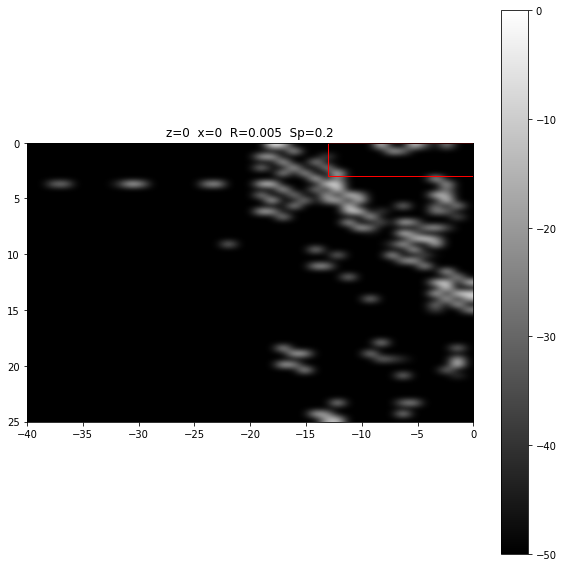

In [ ]:
#print(phantom)
filter = np.array([0.00, .05, .25, .4, .25,  0.05, 0.00])
filter = np.array([0.00, .00, .0, 1, .0,  0.0, 0.00])
#filter = np.array([0.20, .2, .2, .2, .2,  0.2, 0.20])
filter = np.outer(filter, filter)
smoothed = scipy.signal.convolve2d(phantom, filter, mode='same', boundary='symm')

#smoothed = denoise_tv_chambolle(phantom, weight=10e-3)

extent=[-40,0,25,0]
patch=patches.Rectangle((-0, 0), -13, 3, linewidth=1, edgecolor='r', facecolor='none')
PlotImage(smoothed,extent=extent,title='z=0  x=0  R=0.005  Sp=0.2', patch=patch)

## Solve the system of equations

In [ ]:
#compute the resulting image using the ElasticNets reconstructor
reg = 0.2      #lambda
sparsity = 0.05   #alpha
x = solve(H,y,reg,sparsity)

#unravel the image
_cols = int((xmax-xmin)/dx)
_rows = int((zmax-zmin)/dz)

img = np.zeros((_rows,_cols))
for n in range(_rows):
    img[n,:] = x[n*_cols:(n+1)*_cols]

## Various reconstruction simulations

## 5 smaller cysts

Receiver locations:   0.50  1.00  1.50  2.00
Scatter density: 5
Number of pulse cycles: 3
No noise added
Reflections specifified as 1.0
Regularization parameters: alpha=0.002, lambda=0.75
dx: 0.50 dz: 0.50


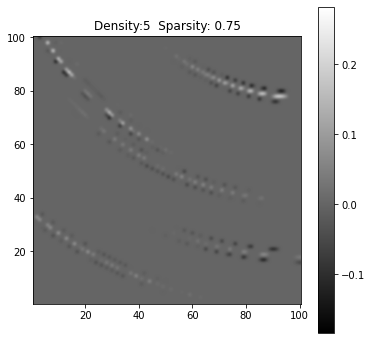

In [ ]:
#Write the parameters used in the simulation
s = 'Receiver locations: '
tmp = rx_locations[:,1]
for t in tmp:
  s = s + '{:6.2f}'.format(t)
print(s)
print('Scatter density: ' + str(scatDensity))
print('Number of pulse cycles: ' + str(cycles))
if( addNoise ): 
    print('Noise added')
else:
     print('No noise added')
if( ranReflections ):
  print('Used random reflections')
else:
  print('Reflections specifified as 1.0')
s = 'Regularization parameters: alpha={:4.3f}'.format(reg)
s = s + ', lambda={:4.2f}'.format(sparsity)
print(s)
s = 'dx: {:4.2f}'.format(dx) + ' ' + 'dz: {:4.2f}'.format(dz)
print(s)
#plot the image with scatter density
fig,ax1 = plt.subplots(figsize=(6,6))
ax1.xaxis.label.set_color(color='white')
pos = plt.imshow(np.log(img+1), cmap='gray',aspect='equal',interpolation='bicubic',extent=(0.5, 0.5+_cols, 0.5, 0.5 + _rows))
plt.title('Density:' + str(scatDensity) + '  ' + 'Sparsity: ' + str(sparsity))
fig.colorbar(pos)

Receiver locations:   2.00  4.00  6.00  8.00
Scatter density: 5
Number of pulse cycles: 3
No noise added
Reflections specifified as 1.0
Regularization parameters: alpha=0.002, lambda=0.75
dx: 0.50 dz: 0.50


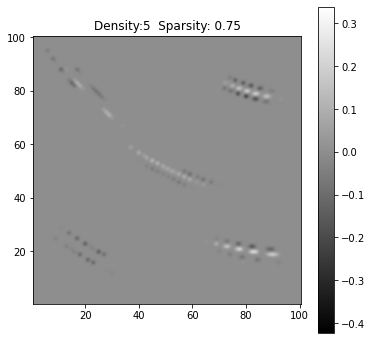

In [ ]:
#Write the parameters used in the simulation
s = 'Receiver locations: '
tmp = rx_locations[:,1]
for t in tmp:
  s = s + '{:6.2f}'.format(t)
print(s)
print('Scatter density: ' + str(scatDensity))
print('Number of pulse cycles: ' + str(cycles))
if( addNoise ): 
    print('Noise added')
else:
     print('No noise added')
if( ranReflections ):
  print('Used random reflections')
else:
  print('Reflections specifified as 1.0')
s = 'Regularization parameters: alpha={:4.3f}'.format(reg)
s = s + ', lambda={:4.2f}'.format(sparsity)
print(s)
s = 'dx: {:4.2f}'.format(dx) + ' ' + 'dz: {:4.2f}'.format(dz)
print(s)
#plot the image with scatter density
fig,ax1 = plt.subplots(figsize=(6,6))
ax1.xaxis.label.set_color(color='white')
pos = plt.imshow(np.log(img+1), cmap='gray',aspect='equal',interpolation='bicubic',extent=(0.5, 0.5+_cols, 0.5, 0.5 + _rows))
plt.title('Density:' + str(scatDensity) + '  ' + 'Sparsity: ' + str(sparsity))
fig.colorbar(pos)

Receiver locations:  -3.00 -1.00  1.00  3.00
Scatter density: 5
Number of pulse cycles: 3
No noise added
Reflections specifified as 1.0
Regularization parameters: alpha=0.002, lambda=0.75
dx: 0.50 dz: 0.50


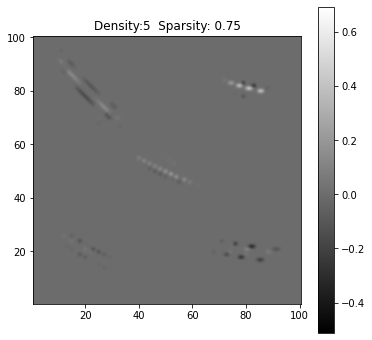

In [ ]:
#Write the parameters used in the simulation
s = 'Receiver locations: '
tmp = rx_locations[:,1]
for t in tmp:
  s = s + '{:6.2f}'.format(t)
print(s)
print('Scatter density: ' + str(scatDensity))
print('Number of pulse cycles: ' + str(cycles))
if( addNoise ): 
    print('Noise added')
else:
     print('No noise added')
if( ranReflections ):
  print('Used random reflections')
else:
  print('Reflections specifified as 1.0')
s = 'Regularization parameters: alpha={:4.3f}'.format(reg)
s = s + ', lambda={:4.2f}'.format(sparsity)
print(s)
s = 'dx: {:4.2f}'.format(dx) + ' ' + 'dz: {:4.2f}'.format(dz)
print(s)
#plot the image with scatter density
fig,ax1 = plt.subplots(figsize=(6,6))
ax1.xaxis.label.set_color(color='white')
pos = plt.imshow(np.log(img+1), cmap='gray',aspect='equal',interpolation='bicubic',extent=(0.5, 0.5+_cols, 0.5, 0.5 + _rows))
plt.title('Density:' + str(scatDensity) + '  ' + 'Sparsity: ' + str(sparsity))
fig.colorbar(pos)

Receiver locations:  -8.00 -6.00 -4.00 -2.00
Scatter density: 5
Number of pulse cycles: 3
No noise added
Reflections specifified as 1.0
Regularization parameters: alpha=0.002, lambda=0.75
dx: 0.50 dz: 0.50


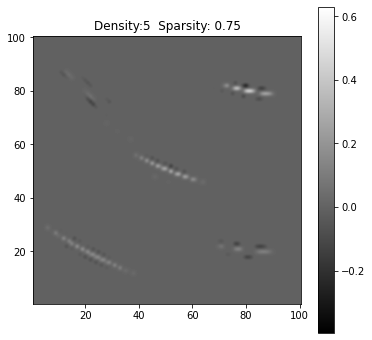

In [ ]:
#Write the parameters used in the simulation
s = 'Receiver locations: '
tmp = rx_locations[:,1]
for t in tmp:
  s = s + '{:6.2f}'.format(t)
print(s)
print('Scatter density: ' + str(scatDensity))
print('Number of pulse cycles: ' + str(cycles))
if( addNoise ): 
    print('Noise added')
else:
     print('No noise added')
if( ranReflections ):
  print('Used random reflections')
else:
  print('Reflections specifified as 1.0')
s = 'Regularization parameters: alpha={:4.3f}'.format(reg)
s = s + ', lambda={:4.2f}'.format(sparsity)
print(s)
s = 'dx: {:4.2f}'.format(dx) + ' ' + 'dz: {:4.2f}'.format(dz)
print(s)
#plot the image with scatter density
fig,ax1 = plt.subplots(figsize=(6,6))
ax1.xaxis.label.set_color(color='white')
pos = plt.imshow(np.log(img+1), cmap='gray',aspect='equal',interpolation='bicubic',extent=(0.5, 0.5+_cols, 0.5, 0.5 + _rows))
plt.title('Density:' + str(scatDensity) + '  ' + 'Sparsity: ' + str(sparsity))
fig.colorbar(pos)

## One larger hollow cyst

Receiver locations: -42.00-39.00-33.00-27.00-21.00-15.00 -9.00 -3.00
Scatter density: 1.1
Number of pulse cycles: 3
No noise added
Reflections specifified as 1.0
Cycst radius: 10.00 mm
Regularization parameters: lambda=0.200, alpha=0.05
dx: 0.50 dz: 0.50


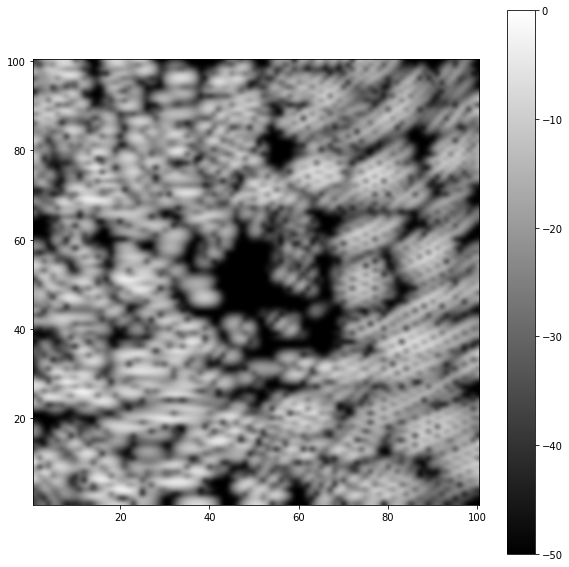

In [ ]:
#Write the parameters used in the simulation
#filter = np.array([0.00, -.05, .25, .6, .25,  -0.05, 0.00])
filter = np.array([0.00, .05, .25, .4, .25,  0.05, 0.00])
#filter = np.array([0.00, .0, .0, .99, .0,  0.0, 0.00])
#filter = np.array([0.05, .1, .2, .25, .2,  .1, 0.05])
filter = np.outer(filter, filter)
smoothed = scipy.signal.convolve2d(img, filter, mode='same', boundary='symm')

#smoothed = denoise_tv_chambolle(img, weight=10e-3)
WriteParameters()
PlotImage(smoothed)

#save_mat_data('radius_10mm_08Rx.mat', img, zs, xs)
#!ls -lh
#%cd

Receiver locations:  20.00 14.00  8.00  2.00
Scatter density: 5
Number of pulse cycles: 3
No noise added
Reflections specifified as 1.0
Cycst radius: 10.00 mm
Regularization parameters: alpha=0.001, lambda=0.40
dx: 0.50 dz: 0.50


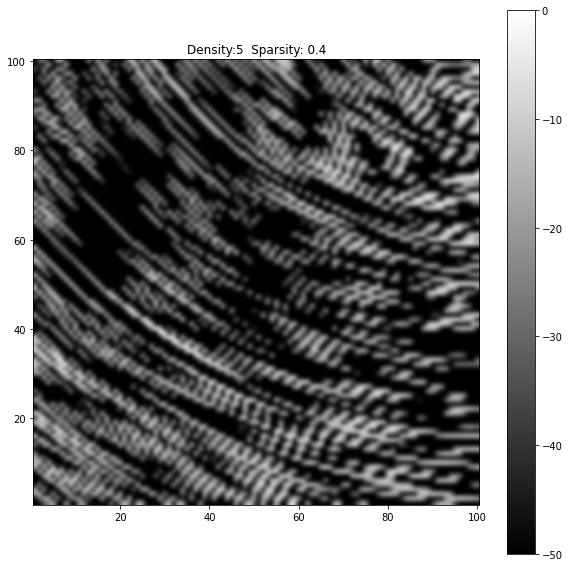

In [ ]:
#Write the parameters used in the simulation
WriteParameters()
PlotImage(img)

Receiver locations:  20.00 14.00  8.00  2.00
Scatter density: 5
Number of pulse cycles: 3
No noise added
Reflections specifified as 1.0
Cycst radius: 10.00 mm
Regularization parameters: alpha=0.001, lambda=0.40
dx: 0.50 dz: 0.50


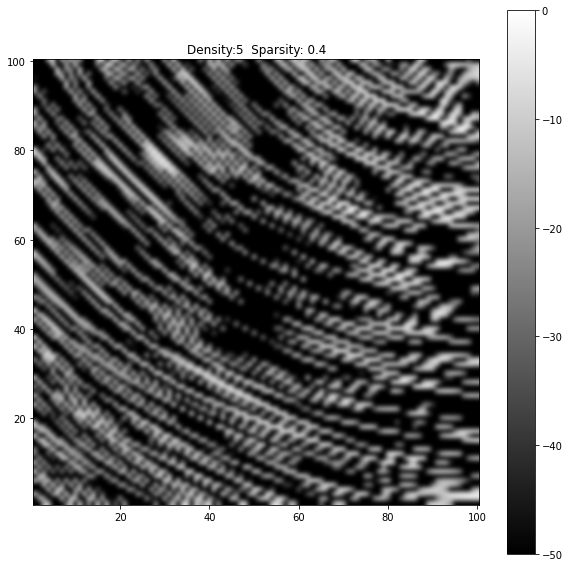

In [ ]:
#Write the parameters used in the simulation
WriteParameters()
PlotImage(img)

# New Section

In [ ]:
save_mat_data('radius_10mm_2WLSpacing.mat', img, zs, xs)
!ls -lh
%cd

100 100
total 252K
-rw-r--r-- 1 root root 248K Jan  6 23:01 radius_10mm_2WLSpacing.mat
drwxr-xr-x 1 root root 4.0K Dec 21 17:29 sample_data
/root


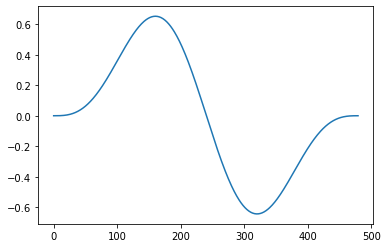

In [ ]:
_cycles=3
_sampFactor = 20
ts = 1 / 12.5e6/ _sampFactor #sampling period of the pulse 
_n = np.array(range(int(_cycles*sampFactor+0.5)))
_pulse = np.sin(2*math.pi*ts*520e3*_n)
_impulse = scipy.signal.hann(len(_n), sym = True) * _pulse
plt.plot(_impulse)

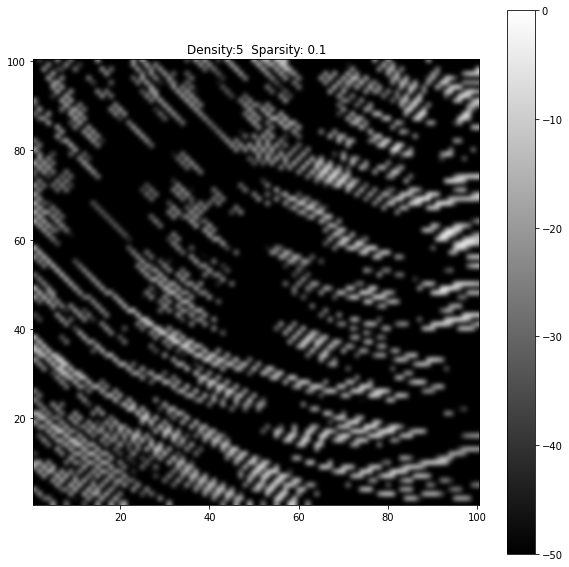

In [ ]:
#compute the result
#img_100_040 = solve(H,y,0.1,0.4)
#img_010_040 = solve(H,y,0.01,0.4)
#img_001_040 = solve(H,y,0.001,0.4)

img_100_010 = solve(H,y,0.01,0.6)

#unravel the image
_cols = int((xmax-xmin)/dx)
_rows = int((zmax-zmin)/dz)

img = np.zeros((_rows,_cols))
for n in range(_rows):
    img[n,:] = img_100_010[n*_cols:(n+1)*_cols]
  
img_100_010 = img

PlotImage(img_100_010)

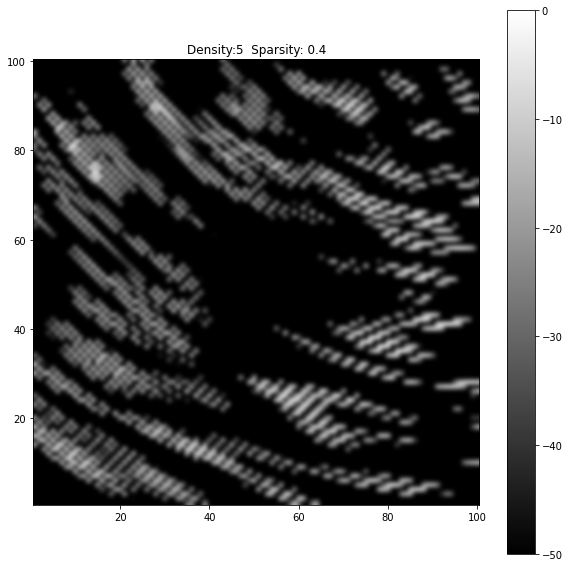

In [ ]:
#Write the parameters used in the simulation
#WriteParameters()
PlotImage(img_100_040)

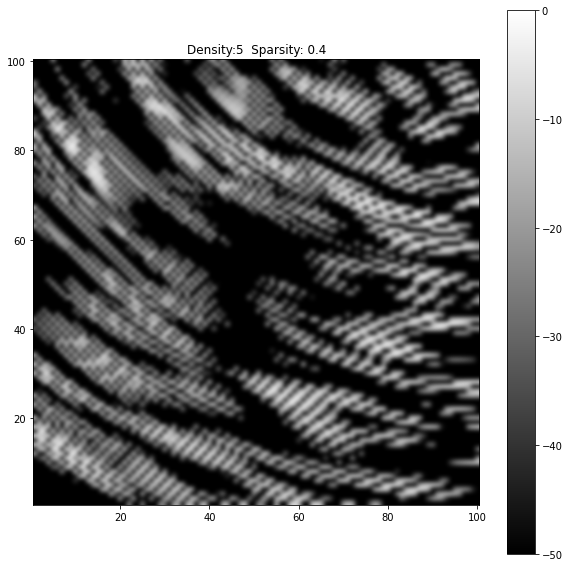

In [ ]:
PlotImage(img_100_020)

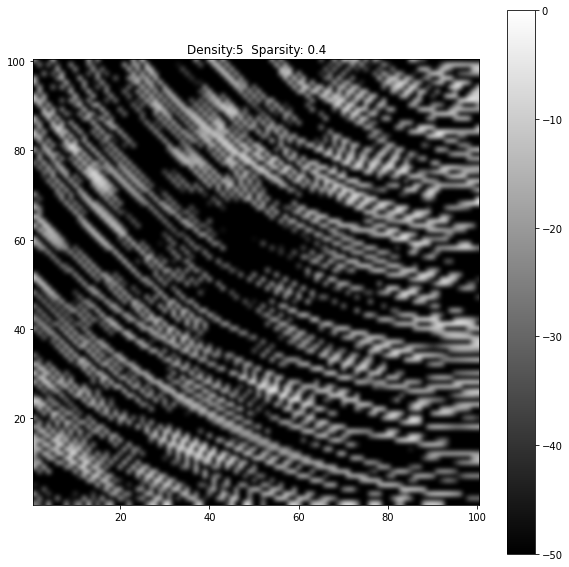

In [ ]:
PlotImage(img_001_040)

In [ ]:
WriteParameters()

Receiver locations:  20.00 14.00  8.00  2.00
Scatter density: 5
Number of pulse cycles: 3
No noise added
Reflections specifified as 1.0
Cycst radius: 10.00 mm
Regularization parameters: alpha=0.020, lambda=0.10
dx: 0.50 dz: 0.50


In [ ]:
import math

math.sqrt(4.859*4.859 + 2.191*2.191)*0.707

3.768406962542395

In [ ]:
math.sqrt(10)*3/3.768

2.51773699057992